# setting up

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import scanpy as sc 

In [2]:
from SingleCellArchetype.main import SCA
from SingleCellArchetype.utils import plot_archetype

# Load data

In [3]:
%%time
f_anndata_in  = "../../data/v1_multiome/superdupermegaRNA_hasraw_multiome_L23.h5ad"
adata = sc.read(f_anndata_in)
adata = adata[adata.obs['Age']=='P21']
adata

CPU times: user 958 ms, sys: 6.95 s, total: 7.91 s
Wall time: 42.8 s


View of AnnData object with n_obs × n_vars = 2213 × 16521
    obs: 'Age', 'Doublet', 'Doublet Score', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'Class', 'Sample', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts_mt', 'Doublet?', 'Study', 'Type_leiden', 'time'
    var: 'feature_types'
    layers: 'norm'

# Prep data - select HVGs

In [4]:
# select samples
adata.obs['cond'] = adata.obs['sample'].apply(lambda x: x[:-1]) # .unique()

# remove mitocondria genes
adata = adata[:,~adata.var.index.str.contains(r'^mt-')]
adata = adata[:,~adata.var.index.str.contains(r'Xist')]

# select
adata.obs['sample'].unique(), adata.obs['cond'].unique()

/tmp/ipykernel_223104/646487602.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cond'] = adata.obs['sample'].apply(lambda x: x[:-1]) # .unique()


(['P21a', 'P21b']
 Categories (2, object): ['P21a', 'P21b'],
 array(['P21'], dtype=object))

In [5]:
# filter genes
cond = np.ravel((adata.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata = adata[:,cond]
genes = adata.var.index.values

# counts
x = adata.X
cov = adata.obs['total_counts'].values

# CP10k
# xn = x/cov.reshape(x.shape[0], -1)*1e4
xn = (sparse.diags(1/cov).dot(x))*1e4

# log2(CP10k+1)
# xln = xn.copy()
# xln.data = np.log2(xln.data+1)

In [6]:
# adata.layers[    'norm'] = np.array(xn.todense())

log_xn = np.log2(1+np.array(xn.todense()))
adata.layers[ 'lognorm'] = log_xn 
adata.layers['zlognorm'] = zscore(log_xn, axis=0)

In [7]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# min
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)
assert np.all(gsel_idx != -1)

In [8]:
adata_hvg = adata[:,gsel_idx]
print(adata_hvg.shape)
genes_hvg = adata_hvg.var.index.values

(2213, 4420)


# Run SingleCellArchetype with different controls

- First, we can infer archetypes using the original data. 
- To assess the **stability** of archetypal inference, we downsample cells (or genes) and repeat the inference.
- To assess the **statistical significance of the archetypal fit**, we **shuffle the data** and compare the shuffled results with data. The effect can be directly visualized, and quantified using t-ratio test. 
- To assess the **significance of the transcriptomic continuum**, we shuffle the data **locally within each cell type (or cluster)**. The effect can be directly visualzed (and later quantified). 

In [9]:
types = [0]*len(adata_hvg)
norm_mat = np.array(adata_hvg.layers['lognorm'])
sca = SCA(norm_mat, types)

In [10]:
ndim = 2
noc = 3
sca.setup_feature_matrix(method='data')
xp, aa = sca.proj_and_pcha(ndim, noc)

nrepeats = 3
p = 0.8
aa_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use data


In [11]:
# gshuff
sca.setup_feature_matrix(method='gshuff')
xp_gshuff, aa_gshuff = sca.proj_and_pcha(ndim, noc)
aa_gshuff_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use shuffled data


In [12]:
# tshuff 
sca.setup_feature_matrix(method='tshuff')
xp_tshuff, aa_tshuff = sca.proj_and_pcha(ndim, noc)
aa_tshuff_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use per-type shuffled data


# plot

In [13]:
types_colorvec = np.char.add('C', sca.types_idx.astype(str))

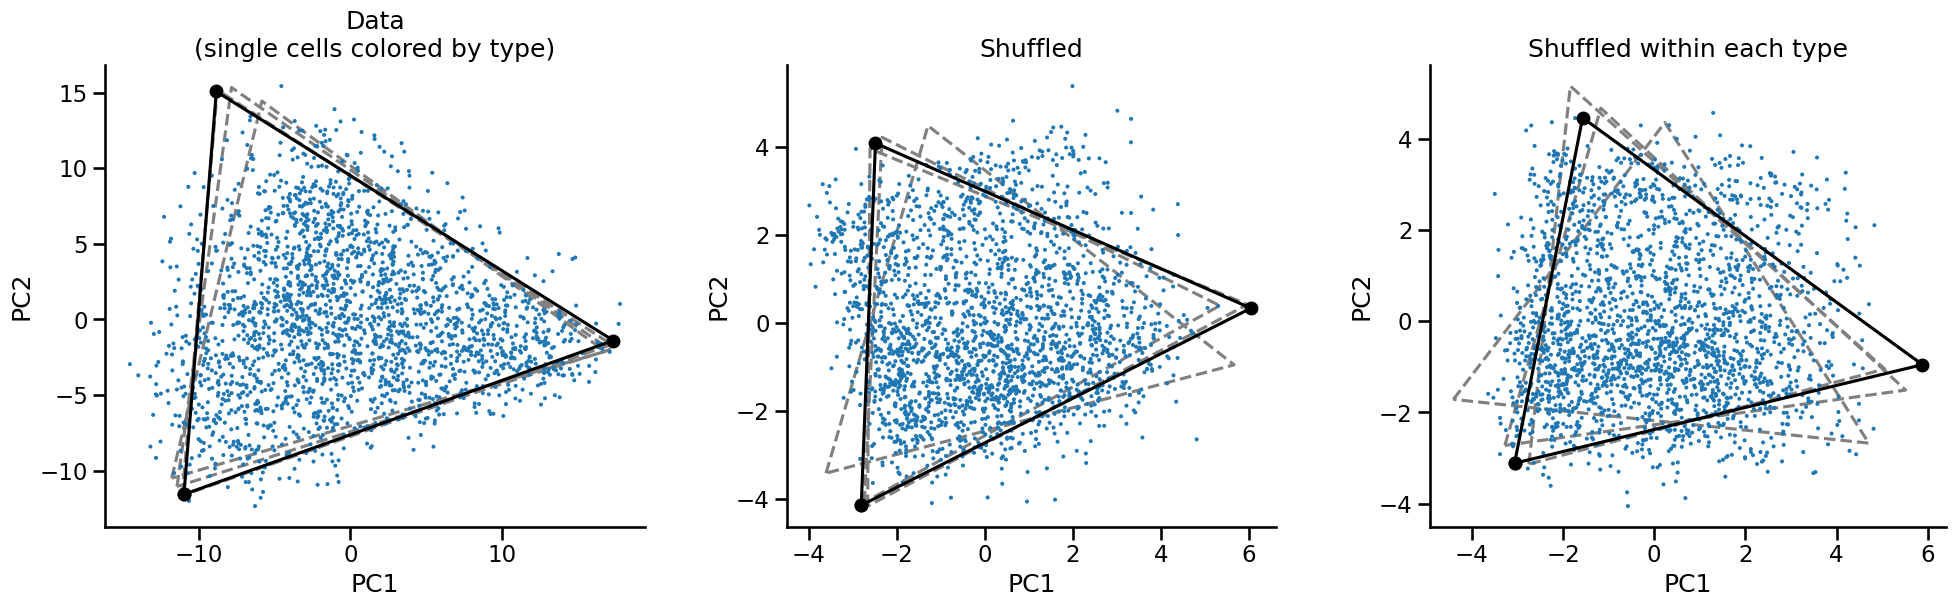

In [14]:
# plot
fig, axs = plt.subplots(1,3,figsize=(8*3,6))
ax = axs[0]
ax.scatter(xp[:,0], xp[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa, fmt='-o', color='k', zorder=2)
for i in range(nrepeats):
    plot_archetype(ax, aa_dsamps[i], fmt='--', color='gray', zorder=0)
ax.set_title('Data\n(single cells colored by type)')
    
ax = axs[1]
ax.set_title('Shuffled')
ax.scatter(xp_gshuff[:,0], xp_gshuff[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa_gshuff, fmt='-o', color='k', zorder=2)
for i in range(nrepeats):
    plot_archetype(ax, aa_gshuff_dsamps[i], fmt='--', color='gray', zorder=0)

ax = axs[2]
ax.set_title('Shuffled within each type')
ax.scatter(xp_tshuff[:,0], xp_tshuff[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa_tshuff, fmt='-o', color='k', zorder=2)
for i in range(nrepeats):
    plot_archetype(ax, aa_tshuff_dsamps[i], fmt='--', color='gray', zorder=0)

for i in range(3):
    ax = axs[i]
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_aspect('equal')
    sns.despine(ax=ax)
    ax.grid(False)
    
plt.show()

# quantify t-ratio 

- for 2-dimensional data only

In [15]:
t_ratio, t_ratio_shuffs, pval = sca.t_ratio_test(ndim, noc, nrepeats=20)
print(f'p-value: {pval}')

use data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
p-value: 0.05


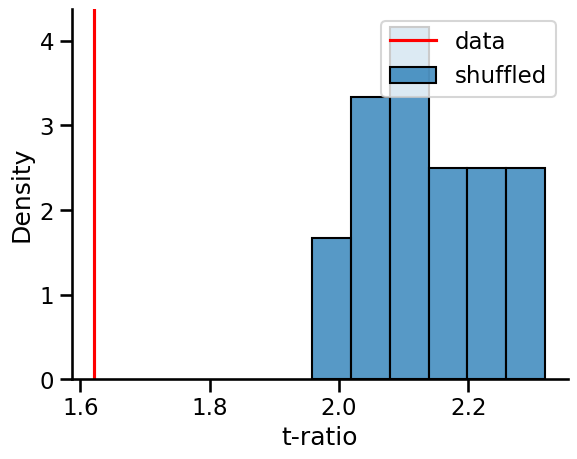

In [16]:
fig, ax = plt.subplots()
ax.axvline(t_ratio, color='r', label='data')
sns.histplot(t_ratio_shuffs, ax=ax, stat='density', label='shuffled')
ax.set_xlabel('t-ratio')
ax.legend()
sns.despine(ax=ax)
plt.show()

# quantify stability

In [17]:
from sklearn.metrics import pairwise_distances

In [18]:
def get_relative_variation(aa_list):
    """
    """
    
    aa_avg = np.mean(aa_list, axis=0).T
    ref = np.mean(pairwise_distances(aa_avg))

    aa_std = np.std(aa_list, axis=0).T
    epsilon = np.mean(np.sqrt(np.sum(np.power(aa_std,2), axis=1)))
    
    return epsilon/ref

In [19]:
var_data   = get_relative_variation(aa_dsamps)
var_gshuff = get_relative_variation(aa_gshuff_dsamps)

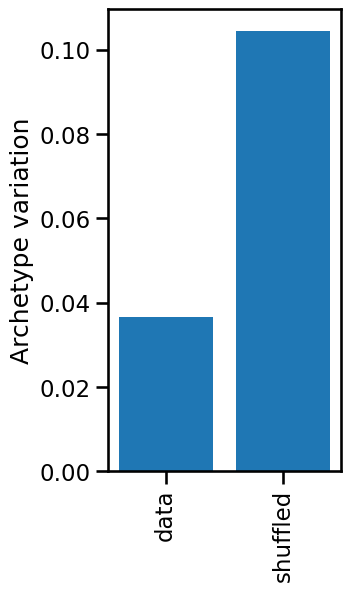

In [20]:
fig, ax = plt.subplots(figsize=(3,6))
ax.bar(np.arange(2), [var_data, var_gshuff])
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['data', 'shuffled'], rotation=90)
ax.set_ylabel('Archetype variation')
plt.show()